In [122]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Create example data
#X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
#df = pd.DataFrame(data=X, columns=['Feature1', 'Feature2'])
df_global = pd.read_csv('../global.csv', encoding='ISO-8859-1')
df_without_norm = pd.read_csv('../global_preprocessed_without_onehot_and_norm.csv')
df = pd.read_csv('../global_preprocessed_without_onehot.csv', encoding='ISO-8859-1')
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]

dfh = df[:df.shape[0]//10]
df_without_normh = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]

/tmp/ipykernel_13995/28896384.py:13: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv('../global.csv', encoding='ISO-8859-1')


In [123]:
df_global.rename(columns={'gname': 'gname_txt'}, inplace=True)
df_global['gname'] = pd.factorize(df_global['gname_txt'])[0]
attacktype_dict = dict(zip(df_global['attacktype1'], df_global['attacktype1_txt']))
targettype_dict = dict(zip(df_global['targtype1'], df_global['targtype1_txt']))
region_dict = dict(zip(df_global['region'], df_global['region_txt']))
gname_dict = dict(zip(df_global['gname'], df_global['gname_txt']))

In [124]:


# Define the parameter grid
k_values = range(2, 15)   

# Store silhouette scores and k values
silhouette_scores = []
k_values_used = []
kmeans_array = []
# Perform "Grid Search"
for k in k_values:
    print(k)
    kmeans_i = KMeans(n_clusters=k, random_state=0, n_init='auto', max_iter=100)
    kmeans_i.fit(df)
    score = silhouette_score(df, kmeans_i.labels_,  sample_size=1000)
    silhouette_scores.append(score)
    kmeans_array.append(kmeans_i)
    k_values_used.append(k)

2
3
4
5
6
7
8
9
10
11
12
13
14


Best k: 2


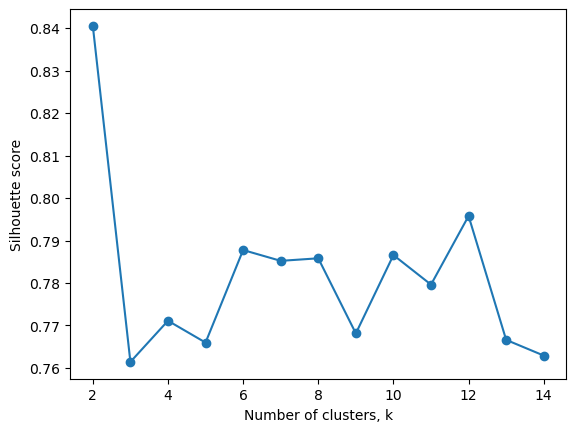

In [125]:
# Determine the best k
best_k = k_values_used[silhouette_scores.index(max(silhouette_scores))]
kmeans = kmeans_array[silhouette_scores.index(max(silhouette_scores))]
print('Best k:', best_k)

# Plot
plt.plot(k_values_used, silhouette_scores, marker='o')
plt.xlabel("Number of clusters, k")
plt.ylabel("Silhouette score")
plt.show()

In [126]:
df['KMeans_labels'] = kmeans.labels_
df_without_norm['KMeans_labels'] = kmeans.labels_

In [127]:
eps_vals = np.linspace(0.3, 1.5, 10)
min_samples_vals = range(2, 10, 1)

best_score = -1
best_eps = None
best_dbscan = None
best_min_samples = None


In [128]:
# DBSCAN clustering
for eps in eps_vals:
    print(eps)
    for min_samples in min_samples_vals:
        print(min_samples)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        # Fit the model
        labels = dbscan.fit_predict(df)
        
        # Ignore cases where the clustering resulted in only one cluster or noise
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df, labels, sample_size=1000)
            
            # If the silhouette score is better, store these parameters as the best
            if score > best_score:
                best_dbscan = dbscan
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

0.3
2
3
4
5
6
7
8
9
0.43333333333333335
2
3
4
5
6
7
8
9
0.5666666666666667
2
3
4
5
6
7
8
9
0.7
2
3
4
5
6
7
8
9
0.8333333333333333
2
3
4
5
6
7
8
9
0.9666666666666666
2
3
4
5
6
7
8
9
1.1
2
3
4
5
6
7
8
9
1.2333333333333334
2
3
4
5
6
7
8
9
1.3666666666666667
2
3
4
5
6
7
8
9
1.5
2
3
4
5
6
7
8
9


In [129]:
dbscan = best_dbscan
df['DBSCAN_labels'] = dbscan.labels_
df_without_norm['DBSCAN_labels'] = dbscan.labels_

In [130]:

try:
    # Hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=best_k)
    agg_clustering.fit(dfh)
    dfh['Hierarchical_labels'] = agg_clustering.labels_
    df_without_normh['Hierarchical_labels'] = agg_clustering.labels_
except:
    pass

/tmp/ipykernel_13995/1514165139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh['Hierarchical_labels'] = agg_clustering.labels_
/tmp/ipykernel_13995/1514165139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_normh['Hierarchical_labels'] = agg_clustering.labels_


In [131]:
# Evaluation
print(f"KMeans silhouette score: {silhouette_score(df, kmeans.labels_, sample_size=1000):.2f}")
print(f"DBSCAN silhouette score: {silhouette_score(df, dbscan.labels_, sample_size=1000):.2f}")
try:
    print(f"Hierarchical silhouette score: {silhouette_score(dfh, agg_clustering.labels_, sample_size=1000):.2f}")
except:
    pass

KMeans silhouette score: 0.76
DBSCAN silhouette score: 0.36
Hierarchical silhouette score: 0.69


In [132]:
# Comparison with true labels
#print(f"KMeans Adjusted Rand Index: {adjusted_rand_score(df, df['KMeans_labels']):.2f}")
#print(f"DBSCAN Adjusted Rand Index: {adjusted_rand_score(df, df['DBSCAN_labels']):.2f}")
#print(f"Hierarchical Adjusted Rand Index: {adjusted_rand_score(df, df['Hierarchical_labels']):.2f}")

In [133]:
df_KMeans = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_KMeans.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_KMeans = pd.merge(df_KMeans, mode_df, on='KMeans_labels', how='left')
    df_KMeans.drop(label + '_x', axis=1, inplace=True)
    df_KMeans.rename(columns={label + '_y': label}, inplace=True)

In [134]:
df_KMeans = df_KMeans.groupby("KMeans_labels").mean()
df_KMeans["targtype1"] = df_KMeans['targtype1'].map(targettype_dict)
df_KMeans["region"] = df_KMeans['region'].map(region_dict)
df_KMeans["gname"] = df_KMeans['gname'].map(gname_dict)
df_KMeans["attacktype1"] = df_KMeans['attacktype1'].map(attacktype_dict)
df_KMeans

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,DBSCAN_labels,attacktype1,targtype1,region,gname
KMeans_labels,,,,,,,,,,,,,
0,2010.965449,0.093035,4.022799,4.762999,4.519238,0.083984,0.901906,0.003108,1522.295417,Bombing/Explosion,Private Citizens & Property,South Asia,Association of Demobilized Armed Forces
1,1999.860527,0.030173,1.467547,2.279308,2.294473,0.018923,0.883192,0.003019,162.515055,Bombing/Explosion,Private Citizens & Property,Middle East & North Africa,Unknown


In [141]:
df_DBSCAN = df_without_norm.copy()

In [142]:
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_DBSCAN.groupby('DBSCAN_labels')[label].agg(pd.Series.mode).reset_index()
    df_DBSCAN = pd.merge(df_DBSCAN, mode_df, on='DBSCAN_labels', how='left')
    df_DBSCAN.drop(label + '_x', axis=1, inplace=True)
    df_DBSCAN.rename(columns={label + '_y': label}, inplace=True)

In [146]:
df_DBSCAN = df_DBSCAN.groupby("DBSCAN_labels").mean(numeric_only=False)
#df_DBSCAN["targtype1"] = df_DBSCAN['targtype1'].map(targettype_dict)
#df_DBSCAN["region"] = df_DBSCAN['region'].map(region_dict)
#df_DBSCAN["gname"] = df_DBSCAN['gname'].map(gname_dict)
#df_DBSCAN["attacktype1"] = df_DBSCAN['attacktype1'].map(attacktype_dict)
df_DBSCAN

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,attacktype1,targtype1,region,gname
DBSCAN_labels,,,,,,,,,,,,,
-1,1997.046967,0.094399,8.886777,12.758177,18.153294,0.044917,0.906812,0.015003,0.484577,3.0,14.0,10.0,2.0
0,2005.062422,0.029008,1.198383,2.367520,0.970325,0.027421,0.864190,0.001637,1.000000,3.0,14.0,10.0,2.0
1,1970.090909,0.000000,0.090909,0.000000,4.090909,0.000000,0.909091,0.000000,1.000000,3.0,1.0,3.0,4.0
2,1970.323529,0.000000,0.000000,0.014706,1.161765,0.000000,0.897059,0.000000,1.000000,7.0,2.0,1.0,7.0
3,1970.798450,0.007752,0.054264,0.100775,0.852713,0.000000,0.713178,0.000000,1.000000,3.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,2017.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,9.0,14.0,8.0,3472.0
2590,2017.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.500000,0.000000,1.000000,7.0,"[14.0, 15.0]",8.0,1019.0
2591,2017.000000,0.000000,7.500000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.0,14.0,11.0,3474.0


In [147]:
try:
    df_Hierarc = df_without_normh
    for label in ["attacktype1", "targtype1", "region", "gname"]:    
        mode_df = df_Hierarc.groupby('Hierarchical_labels')[label].agg(pd.Series.mode).reset_index()
        df_Hierarc = pd.merge(df_Hierarc, mode_df, on='Hierarchical_labels', how='left')
        df_Hierarc.drop(label + '_x', axis=1, inplace=True)
        df_Hierarc.rename(columns={label + '_y': label}, inplace=True)
except:
    pass

In [148]:
try:
    df_Hierarc = df_Hierarc.groupby("Hierarchical_labels").mean(numeric_only=False)
    df_Hierarc["targtype1"] = df_Hierarc['targtype1'].map(targettype_dict)
    df_Hierarc["region"] = df_Hierarc['region'].map(region_dict)
    df_Hierarc["gname"] = df_Hierarc['gname'].map(gname_dict)
    df_Hierarc["attacktype1"] = df_Hierarc['attacktype1'].map(attacktype_dict)
    #print(df_Hierarc)
except:
    pass
df_Hierarc

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,attacktype1,targtype1,region,gname
Hierarchical_labels,,,,,,,,,,,,
0,1979.728379,0.020148,1.268960,1.259456,3.980802,0.00019,0.924539,0.003421,Bombing/Explosion,Business,Central America & Caribbean,People's Armed Revolutionary Branch
1,1977.534423,0.020814,0.827252,0.967136,1.463554,0.00000,0.896183,0.002022,Bombing/Explosion,Business,Western Europe,Unknown


In [ ]:

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].scatter(df['nkill'], df['nperps'])
ax[0].set_title('Original')

ax[1].scatter(df['nkill'], df['nperps'], c=df['KMeans_labels'])
ax[1].set_title('KMeans')

ax[2].scatter(df['nkill'], df['nperps'], c=df['DBSCAN_labels'])
ax[2].set_title('DBSCAN')
try:
    ax[3].scatter(dfh['nkill'], dfh['nperps'], c=dfh['Hierarchical_labels'])
    ax[3].set_title('Hierarchical')
except:
    pass
plt.show()


In [ ]:
print(len(set(df['KMeans_labels'])), len(set(df['DBSCAN_labels'])), len(set(dfh['Hierarchical_labels'])))